# Setup

In [2]:
import pathlib
import pandas as pd
import numpy as np
from itertools import combinations
import os
from tqdm import tqdm
import requests
from datetime import datetime
import geopandas as gpd
import matplotlib.pyplot as plt

In [3]:
path = pathlib.Path().resolve()

# 1. Prepare CT NV Registrations Data

In [43]:
ct_vin_data = pd.read_csv(path / "ignored-data" / "US_Yale_University_OP0001562727_NV_CT_VIN_Prefix_202212.txt", sep = '|')

In [44]:
ct_vin_data["VEH_COUNT"].sum()

975076

## 1a. Initial Descriptives - CT NV Registration Data

In [18]:
max_date = max(ct_vin_data["everREPORT_YEAR_MONTH"])
min_date = min(ct_vin_data["everREPORT_YEAR_MONTH"])
print(f"The data goes from {min_date} to {max_date}")

The data goes from 201801 to 202212


In [19]:
len(ct_vin_data)

924477

In [84]:
ct_vin_data["VEH_COUNT"].sum()

975076

Count how many cars sold in 2018

In [86]:
ct_vin_data["YEAR"] = ct_vin_data["everREPORT_YEAR_MONTH"].astype(str).str[:4]

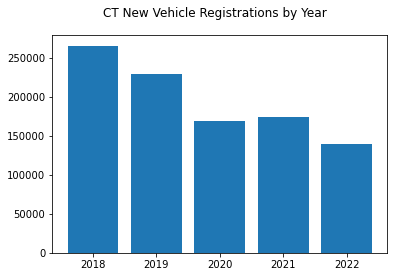

In [110]:
fig, ax = plt.subplots(nrows =1, ncols = 1)

ax.bar(x = "YEAR",
        height = "VEH_COUNT",
        data = ct_vin_data[["YEAR", "VEH_COUNT"]].groupby("YEAR").sum().reset_index())

fig.suptitle("CT New Vehicle Registrations by Year")

plt.show()

## 1b. Change VIN format to match with NHTSA

In [64]:
ct_vin_data.head()

,everREPORT_YEAR_MONTH,MAKE,MODEL,MODEL_YEAR,TRANSACTION_PRICE,ZIP_CODE,VIN_PREFIX,COUNTY_NAME,STATE_ABBRV,VEH_COUNT,YEAR
0,201909,HONDA,CR-V,2019,25750.0,6461,2HKRW6H39K,NEW HAVEN,CT,1,2019
1,201902,HONDA,CIVIC,2019,17522.0,6512,2HGFC2F65K,NEW HAVEN,CT,1,2019
2,201909,KIA,FORTE,2019,NaN,6078,3KPF24AD2K,HARTFORD,CT,1,2019
3,201911,LEXUS,RX,2020,55356.0,6037,2T2YGMDA2L,HARTFORD,CT,1,2019
4,201907,HONDA,CR-V,2019,25769.0,6084,2HKRW6H32K,TOLLAND,CT,1,2019


In [139]:
ct_vin_data["VIN_PREFIX_NEW"] = ct_vin_data["VIN_PREFIX"].str[0:8]+"*"+ct_vin_data["VIN_PREFIX"].str[9:10]

# 2. Prepare NHTSA VIN dataset

In [129]:
nhtsa_cleaned  = pd.read_csv(path / "ignored-data" / "NHTSA_cleaned.csv")

C:\Users\rajan\AppData\Local\Temp\ipykernel_4236\1854640047.py:1: DtypeWarning: Columns (7,9,10,13,20,25,30,34,42,44,56,58,68,78,80,114,115,138,146) have mixed types. Specify dtype option on import or set low_memory=False.
  nhtsa_cleaned  = pd.read_csv(path / "ignored-data" / "NHTSA_cleaned.csv")


In [113]:
len(nhtsa_cleaned)

72136

Make the nhtsa code ready for matching (we need to drop the final character).

In [129]:
pd.set_option('display.max_columns', None)

In [131]:
# So here the issue was that there was an error with the VIN, that was then corrected.
nhtsa_cleaned[nhtsa_cleaned["VIN"].str[0:10]=="2HKRW6H3*K"]

,vin_row_start,ABS,ActiveSafetySysNote,AdaptiveCruiseControl,AdaptiveDrivingBeam,AdaptiveHeadlights,AdditionalErrorText,AirBagLocCurtain,AirBagLocFront,AirBagLocKnee,AirBagLocSeatCushion,AirBagLocSide,AutoReverseSystem,AutomaticPedestrianAlertingSound,AxleConfiguration,Axles,BasePrice,BatteryA,BatteryA_to,BatteryCells,BatteryInfo,BatteryKWh,BatteryKWh_to,BatteryModules,BatteryPacks,BatteryType,BatteryV,BatteryV_to,BedLengthIN,BedType,BlindSpotIntervention,BlindSpotMon,BodyCabType,BodyClass,BrakeSystemDesc,BrakeSystemType,BusFloorConfigType,BusLength,BusType,CAN_AACN,CIB,CashForClunkers,ChargerLevel,ChargerPowerKW,CoolingType,CurbWeightLB,CustomMotorcycleType,DaytimeRunningLight,DestinationMarket,DisplacementCC,DisplacementCI,DisplacementL,Doors,DriveType,DriverAssist,DynamicBrakeSupport,EDR,ESC,EVDriveUnit,ElectrificationLevel,EngineConfiguration,EngineCycles,EngineCylinders,EngineHP,EngineHP_to,EngineKW,EngineManufacturer,EngineModel,EntertainmentSystem,ErrorCode,ErrorText,ForwardCollisionWarning,FuelInjectionType,FuelTypePrimary,FuelTypeSecondary,GCWR,GCWR_to,GVWR,GVWR_to,KeylessIgnition,LaneCenteringAssistance,LaneDepartureWarning,LaneKeepSystem,LowerBeamHeadlampLightSource,Make,MakeID,Manufacturer,ManufacturerId,Model,ModelID,ModelYear,MotorcycleChassisType,MotorcycleSuspensionType,NCSABodyType,NCSAMake,NCSAMapExcApprovedBy,NCSAMapExcApprovedOn,NCSAMappingException,NCSAModel,NCSANote,NonLandUse,Note,OtherBusInfo,OtherEngineInfo,OtherMotorcycleInfo,OtherRestraintSystemInfo,OtherTrailerInfo,ParkAssist,PedestrianAutomaticEmergencyBraking,PlantCity,PlantCompanyName,PlantCountry,PlantState,PossibleValues,Pretensioner,RearAutomaticEmergencyBraking,RearCrossTrafficAlert,RearVisibilitySystem,SAEAutomationLevel,SAEAutomationLevel_to,SeatBeltsAll,SeatRows,Seats,SemiautomaticHeadlampBeamSwitching,Series,Series2,SteeringLocation,SuggestedVIN,TPMS,TopSpeedMPH,TrackWidth,TractionControl,TrailerBodyType,TrailerLength,TrailerType,TransmissionSpeeds,TransmissionStyle,Trim,Trim2,Turbo,VIN,ValveTrainDesign,VehicleDescriptor,VehicleType,WheelBaseLong,WheelBaseShort,WheelBaseType,WheelSizeFront,WheelSizeRear,Wheels,Windows,CAid,EPAid
38636,84501,Standard,NaN,NaN,NaN,NaN,NaN,1st and 2nd Rows,1st Row (Driver and Passenger),NaN,NaN,1st Row (Driver and Passenger),Standard,Standard,NaN,2.0,25750.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sport Utility Vehicle (SUV)/Multi-Purpose Vehi...,NaN,NaN,Not Applicable,NaN,Not Applicable,NaN,NaN,NaN,NaN,NaN,Water,NaN,Not Applicable,Standard,NaN,2400.0,146.456986,2.4,5.0,4WD,NaN,Standard,NaN,Standard,NaN,NaN,In-Line,4.0,4.0,184.0,NaN,137.2088,Honda,K24W9/K24V9,NaN,6,6 - Incomplete VIN,NaN,NaN,Gasoline,NaN,NaN,NaN,"Class 1C: 4,001 - 5,000 lb (1,814 - 2,268 kg)",NaN,Standard,NaN,NaN,NaN,NaN,HONDA,474.0,HONDA,990,CR V,1865.0,2019,Not Applicable,Not Applicable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Direct Fuel Injection,NaN,"seat belts: front, rear, rear center",NaN,NaN,NaN,ALLISTON,NaN,CANADA,ONTARIO,NaN,NaN,NaN,NaN,Standard,NaN,NaN,Manual,2.0,5.0,Standard,LX,NaN,Left-Hand Drive (LHD),NaN,Direct,NaN,NaN,Standard,Not Applicable,NaN,Not Applicable,NaN,Continuously Variable Transmission (CVT),NaN,NaN,NaN,2HKRW6H3*KH,Dual Overhead Cam (DOHC),2HKRW6H3*KH,MULTIPURPOSE PASSENGER VEHICLE (MPV),NaN,104.7,NaN,17.0,17.0,4.0,NaN,30301.0,11237.0
38637,84501,Standard,NaN,NaN,NaN,NaN,"In the Possible values section, the Numeric va...",1st and 2nd Rows,1st Row (Driver and Passenger),NaN,NaN,1st Row (Driver and Passenger),Standard,Standard,NaN,2.0,25750.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sport Utility Vehicle (SUV)/Multi-Purpose Vehi...,NaN,NaN,Not Applicable,NaN,Not Applicable,NaN,NaN,NaN,NaN,NaN,Water,NaN,Not Applicable,Standard,NaN,2400.0,146.456986,2.4,5.0,4WD,NaN,Standard,NaN,Standard,NaN,NaN,In-Line,4.0,4.0,184.0,NaN,137.2088,Honda,K24W9/K24V9,NaN,"4,6,14","4 - VIN corrected, error in one position only ...",NaN,NaN,Gasoline,NaN,NaN,NaN,"Class 1C: 4,001 - 5,000 lb (1,81

***
# Identify duplicate VINS in NHTSA dataset
**Note:**
* NHTSA uses the first 11 alpha-numerics with the check variable in the 9th place replaced by '\*': ie ABCEDFGH\*JK
* RL Polk just uses the first 10 alpha-numerics including the check variable. ie ABCEDFGHIJ
* Therefore, to merge on the NHTSA VIN dataset, we must first **drop the 11th alpha-numeric**. However, this **leads to duplicates in the NHTSA VIN list** since VINs that were previously separate now become identical.

To address this, we undertake a quality check to determine how much 10-long VINS within the same 11-long family differ from one another. If they do not differ on meaningful characteristics, then we can arbitrarily drop the 11th character and simply choose the first 10-long VIN matching that pattern

### Inspect those VINS that are not unique

In [114]:
# Get those rows that are not unique

# Create a copy of the initial list
nhtsa_cleaned_notunique = nhtsa_cleaned.copy(deep = True)

# Drop the 11th character of the VINs in the first list
nhtsa_cleaned_notunique["VIN"] = nhtsa_cleaned_notunique["VIN"].str[0:10]

# Create counter to sum
nhtsa_cleaned_notunique["counter"] = 1

# Group by VIN and take a count. The count of the column "counter" reflects the number of repeats
nhtsa_cleaned_notunique_grouped = nhtsa_cleaned_notunique.groupby("VIN").count().reset_index()

In [115]:
# View result
nhtsa_cleaned_notunique_grouped.head()

,VIN,vin_row_start,ABS,ActiveSafetySysNote,AdaptiveCruiseControl,AdaptiveDrivingBeam,AdaptiveHeadlights,AdditionalErrorText,AirBagLocCurtain,AirBagLocFront,...,WheelBaseLong,WheelBaseShort,WheelBaseType,WheelSizeFront,WheelSizeRear,Wheels,Windows,CAid,EPAid,counter
0,19UDE2F3*G,1,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,1,1,1
1,19UDE2F3*H,3,3,3,0,3,0,1,3,3,...,0,3,0,3,3,3,0,3,3,3
2,19UDE2F3*J,2,2,2,2,0,0,1,2,2,...,0,2,0,2,2,2,0,2,2,2
3,19UDE2F3*K,1,1,0,1,0,0,0,1,1,...,0,1,0,1,1,1,0,1,1,1
4,19UDE2F3*L,7,7,0,0,0,0,0,7,7,...,0,7,0,0,0,7,0,7,0,7


In [116]:
# See how long this is
print(f"The length of the grouped dataset is {len(nhtsa_cleaned_notunique_grouped)}")

The length of the grouped dataset is 48645


In [ ]:
# Create a list of the nonunique VINs

# To do this, we take all of the VINs with a counter of greater than 1.
# This is the list of 10-digit VINs, belonging to an 11-digit family, that has more than 1 member (i.e.;
# 10-digit VINs that have siblings)
vins_not_unique = list(nhtsa_cleaned_notunique_grouped[nhtsa_cleaned_notunique_grouped["counter"]>1]["VIN"])

In [117]:
len(nhtsa_cleaned)

72136

In [371]:
# Look to see how many of these VINs there are
len(vins_not_unique)

12590

In [372]:
# Create a subset of the initial DF, containing only non-unique VINs
nhtsa_cleaned_notunique_only = nhtsa_cleaned_notunique.loc[nhtsa_cleaned_notunique.VIN.isin(vins_not_unique), :]
len(nhtsa_cleaned_notunique_only)

36081

### Explanation
We have cleaned the NHTSA dataframe to contain only entries for 10-digit VINs, belonging to multi-member 11-digit families. That is, when we shorten from an 11-digit to a 10-digit VIN by dropping the 11th digit, these are the VINs that now look identical to some other VIN.

We now investigate how similar the vehicle attributes are for these VINs

### Log differences between identical VINs

In [373]:
# Replace all NaNs with 0 to facilitate comparison later on
nhtsa_cleaned_notunique_only = nhtsa_cleaned_notunique_only.replace(np.nan,0)

In [367]:
# Create a file to record progress
outfh_path = path / "data" / "outputs" / "track_diffs.txt"
out_fh = open(outfh_path, "w" if not os.path.exists(outfh_path) else "a")

In [ ]:
# This function will output a large text file, containing all the differences between
# Rows that share the same VIN
# 
# def diffs(df):
#     index = 0
#     num_indices = len(vins_not_unique)
#     # Do this for every VIN in the non unique vins list 
#     for vin in vins_not_unique:
#         if (index % 500 == 0):
#             print(f"Working on index number {index} of {num_indices}")
#         
#         # Extract the entries of the dataframe with that VIN
#         entries = df[df["VIN"] == vin].reset_index()
#         num_entries = len(entries)
#         
#         # Record it in the log file
#         out_fh.write(f"Working on VIN number {vin}, number of entries: {num_entries}\n")
#         
#         # Only if that VIN is to be found
#         if num_entries > 0:
#             
#             # Create a list of all possible combinations of rows
#             combos = list(combinations(list(np.arange(0, num_entries)), 2))
#             
#             # Go column by column
#             columns = list(entries.columns)
#             columns.remove("index")
#             columns.remove("vin_row_start")
#             
#             for column in columns:
#                 diff_count = 0
#                 cells = list(entries[column])
#                 
#                 # Compare combos
#                 for combo in combos:
#                     if (cells[combo[0]] != cells[combo[1]]):
#                         out_fh.write(f"... Difference in column {column}:\n")
#                         out_fh.write(f"... ... Difference between {cells[combo[0]]} and {cells[combo[1]]}\n")
#                         
#             index +=1
#     out_fh.close()
# 
# diffs(nhtsa_cleaned_notunique_only)

This text file shows that the majority of the differences between vehicles that share the same shortened 10-digit VIN  are aesthetic only. That is, they pertain mostly to the following columns:
* AdditionalErrorText
* ErrorCode
* ErrorText
* PlantState
* PlantCounty
* VehicleDescriptor

These differences mean we should be able to freely drop the 11th digit, and simply match on the 10 remaining (we can choose the first row for which that 10-digit VIN appears).

## Prepare NHTSA dataset for merge

In [132]:
# Create a new DF
nhtsa_for_merge = nhtsa_cleaned.copy(deep = True)

# Set VINs to 10-long
nhtsa_for_merge["VIN"] = nhtsa_cleaned["VIN"].str[0:10]

# Those with drop set to 0 are to be kept
nhtsa_for_merge["drop"] = 0

# Sort by VIN so we can check the row above
nhtsa_for_merge = nhtsa_for_merge.sort_values("VIN").reset_index()

In [133]:
# Loop through the rows and find if the VIN is the same as the VIN above
# If it is, mark it to be dropped
for index, row in tqdm(nhtsa_for_merge.iterrows()):
    if nhtsa_for_merge.iloc[index, nhtsa_for_merge.columns.get_loc("VIN")] == nhtsa_for_merge.iloc[index - 1,  nhtsa_for_merge.columns.get_loc("VIN")]:
        nhtsa_for_merge.iloc[index, nhtsa_for_merge.columns.get_loc("drop")] = 1

72136it [00:12, 5963.04it/s]


In [134]:
# Drop all marked as 1
nhtsa_for_merge = nhtsa_for_merge[nhtsa_for_merge["drop"]==0]

In [135]:
# Prepare the EV drive unit
nhtsa_for_merge["EVDriveUnit"] = nhtsa_for_merge["EVDriveUnit"].fillna('non-ev')

# Drop unnecessary columns
nhtsa_for_merge = nhtsa_for_merge.iloc[:, nhtsa_for_merge.columns.isin(["VIN", "EVDriveUnit", "FuelTypePrimary"])]

In [136]:
# Observe different fuel types
nhtsa_cleaned["FuelTypePrimary"].unique()

array(['Gasoline', nan, 'Electric', 'Diesel',
       'Flexible Fuel Vehicle (FFV)', 'Compressed Natural Gas (CNG)',
       'Ethanol (E85)', 'Liquefied Petroleum Gas (propane or LPG)',
       'Compressed Hydrogen/Hydrogen', 'Fuel Cell'], dtype=object)

***

# Match New Vehicle Dataset and NHTSA VIN dataset

### Prepare and match Data

In [137]:
# Prepare CT RLPolk data to merege
ct_vin_data_to_match = ct_vin_data.loc[:, ~ct_vin_data.columns.isin(["VIN_PREFIX", "TRANSACTION_PRICE"])]

In [140]:
# Match
match_4 = ct_vin_data.merge(nhtsa_for_merge, how = 'left', left_on = "VIN_PREFIX_NEW", right_on = "VIN")

In [142]:
# Save match
match_4.to_csv(path / "data" / "outputs" / "new_vehicles_match_4.csv")

In [46]:
match_4 = pd.read_csv(path / "data" / "outputs" / "new_vehicles_match_4.csv")

In [47]:
match_4["VEH_COUNT"].sum()

975076

### Check quality
Note: We use [this](https://portal.ct.gov/-/media/DEEP/air/mobile/CHEAPR/EV-Reg-Fact-Sheet.pdf) fact sheet to check quality. 

##  Unmatched VINs

In [501]:
# First, check the number of rows that have not been matched
unmatched_count = match_4["VIN"].isna().sum()
unmatched_count

295950

In [ ]:
# Get a list of unmatched vins
unmatched = list(match_4[match_4["VIN"].isna()]["VIN_PREFIX_NEW"].unique())

In [527]:
# The number of unique VIN Prefixes that we did not locate in our NHTSA database
len(unmatched)

9826

In [503]:
# Take an example unmatched VIN
match_4[match_4["VIN"].isna()].iloc[0,:]

everREPORT_YEAR_MONTH        201902
MAKE                          HONDA
MODEL                         CIVIC
MODEL_YEAR                     2019
TRANSACTION_PRICE           17522.0
ZIP_CODE                       6512
VIN_PREFIX               2HGFC2F65K
COUNTY_NAME               NEW HAVEN
STATE_ABBRV                      CT
VEH_COUNT                         1
YEAR                           2019
VIN_PREFIX_NEW           2HGFC2F6*K
EVDriveUnit                     NaN
FuelTypePrimary                 NaN
VIN                             NaN
Name: 1, dtype: object

In [121]:
# See if this VIN_PREFIX_NEW can be identified in the nhtsa_cleaned (i.e. RAW) dataset
nhtsa_cleaned[nhtsa_cleaned["VIN"].str[0:10]=="2HGFC2F6*K"]

,vin_row_start,ABS,ActiveSafetySysNote,AdaptiveCruiseControl,AdaptiveDrivingBeam,AdaptiveHeadlights,AdditionalErrorText,AirBagLocCurtain,AirBagLocFront,AirBagLocKnee,...,VehicleType,WheelBaseLong,WheelBaseShort,WheelBaseType,WheelSizeFront,WheelSizeRear,Wheels,Windows,CAid,EPAid


In [508]:
# Take a second example unmatched VIN
match_4[match_4["VIN"].isna()].iloc[17000,:]

everREPORT_YEAR_MONTH        202012
MAKE                         SUBARU
MODEL                       IMPREZA
MODEL_YEAR                     2021
TRANSACTION_PRICE           22494.0
ZIP_CODE                       6498
VIN_PREFIX               4S3GKAB65M
COUNTY_NAME               MIDDLESEX
STATE_ABBRV                      CT
VEH_COUNT                         1
YEAR                           2020
VIN_PREFIX_NEW           4S3GKAB6*M
EVDriveUnit                     NaN
FuelTypePrimary                 NaN
VIN                             NaN
Name: 52279, dtype: object

In [511]:
# See if this VIN_PREFIX_NEW can be identified in the nhtsa_cleaned (i.e. RAW) dataset
nhtsa_cleaned[nhtsa_cleaned["VIN"].str[0:10]=="4S3GKAB6*M"]

,vin_row_start,ABS,ActiveSafetySysNote,AdaptiveCruiseControl,AdaptiveDrivingBeam,AdaptiveHeadlights,AdditionalErrorText,AirBagLocCurtain,AirBagLocFront,AirBagLocKnee,AirBagLocSeatCushion,AirBagLocSide,AutoReverseSystem,AutomaticPedestrianAlertingSound,AxleConfiguration,Axles,BasePrice,BatteryA,BatteryA_to,BatteryCells,BatteryInfo,BatteryKWh,BatteryKWh_to,BatteryModules,BatteryPacks,BatteryType,BatteryV,BatteryV_to,BedLengthIN,BedType,BlindSpotIntervention,BlindSpotMon,BodyCabType,BodyClass,BrakeSystemDesc,BrakeSystemType,BusFloorConfigType,BusLength,BusType,CAN_AACN,CIB,CashForClunkers,ChargerLevel,ChargerPowerKW,CoolingType,CurbWeightLB,CustomMotorcycleType,DaytimeRunningLight,DestinationMarket,DisplacementCC,DisplacementCI,DisplacementL,Doors,DriveType,DriverAssist,DynamicBrakeSupport,EDR,ESC,EVDriveUnit,ElectrificationLevel,EngineConfiguration,EngineCycles,EngineCylinders,EngineHP,EngineHP_to,EngineKW,EngineManufacturer,EngineModel,EntertainmentSystem,ErrorCode,ErrorText,ForwardCollisionWarning,FuelInjectionType,FuelTypePrimary,FuelTypeSecondary,GCWR,GCWR_to,GVWR,GVWR_to,KeylessIgnition,LaneCenteringAssistance,LaneDepartureWarning,LaneKeepSystem,LowerBeamHeadlampLightSource,Make,MakeID,Manufacturer,ManufacturerId,Model,ModelID,ModelYear,MotorcycleChassisType,MotorcycleSuspensionType,NCSABodyType,NCSAMake,NCSAMapExcApprovedBy,NCSAMapExcApprovedOn,NCSAMappingException,NCSAModel,NCSANote,NonLandUse,Note,OtherBusInfo,OtherEngineInfo,OtherMotorcycleInfo,OtherRestraintSystemInfo,OtherTrailerInfo,ParkAssist,PedestrianAutomaticEmergencyBraking,PlantCity,PlantCompanyName,PlantCountry,PlantState,PossibleValues,Pretensioner,RearAutomaticEmergencyBraking,RearCrossTrafficAlert,RearVisibilitySystem,SAEAutomationLevel,SAEAutomationLevel_to,SeatBeltsAll,SeatRows,Seats,SemiautomaticHeadlampBeamSwitching,Series,Series2,SteeringLocation,SuggestedVIN,TPMS,TopSpeedMPH,TrackWidth,TractionControl,TrailerBodyType,TrailerLength,TrailerType,TransmissionSpeeds,TransmissionStyle,Trim,Trim2,Turbo,VIN,ValveTrainDesign,VehicleDescriptor,VehicleType,WheelBaseLong,WheelBaseShort,WheelBaseType,WheelSizeFront,WheelSizeRear,Wheels,Windows,CAid,EPAid


## Extract unmatched VINs from NHTSA API

In [648]:
# Create a blank DataFrame to fill with queries
resp_df_out = pd.DataFrame([], columns = ["EVDriveUnit", "FuelTypePrimary", "VIN"])

# Proceed through unmatched VINs one by one and query the NHTSA database
for vin in tqdm(unmatched):
    # Set URL
    url = (f"https://vpic.nhtsa.dot.gov/api/vehicles/DecodeVin/{vin}?format=csv")
    
    # Download response
    resp_df = pd.read_csv(url)
    
    # Create a DataFrame for this response
    EVDriveUnit = resp_df.iloc[resp_df[resp_df["variable"]=="EV Drive Unit"].index,3].tolist()[0]
    FuelTypePrimary = resp_df.iloc[resp_df[resp_df["variable"]=="Fuel Type - Primary"].index,3].tolist()[0]
    VIN = f"API: {vin}"
    resp_df_add = pd.DataFrame([[EVDriveUnit, FuelTypePrimary, VIN]], columns = ["EVDriveUnit", "FuelTypePrimary", "VIN"])
   
    # Add this to the master output DataFrame
    resp_df_out = pd.concat([resp_df_out, resp_df_add])

100%|██████████| 9826/9826 [51:21<00:00,  3.19it/s]  


In [42]:
# Save
resp_df_out.to_csv(path / "data" / "outputs" / "nhtsa_queries.csv")

VINs for which there is no response / there is not detailed data available

In [125]:
no_response = resp_df_out[resp_df_out["FuelTypePrimary"].isna()]

In [126]:
len(no_response)

150

We need a pure VIN column to match on

In [40]:
resp_df_out["VIN_ONLY"] = resp_df_out["VIN"].str[5:]

In [124]:
# Load
resp_df_out = pd.read_csv(path / "data" / "outputs" / "nhtsa_queries.csv")

## Resolve unmatched VINs by adding NHTSA queried VINs

In [143]:
# We split match_4 into matched and unmatched segments
match_4_matched = match_4[~match_4["VIN"].isna()]
match_4_unmatched = match_4[match_4["VIN"].isna()]

In [144]:
# For the unmatched part, we merge in the data from the API
match_4_unmatched_fix = match_4_unmatched.merge(resp_df_out, how = 'left', left_on = 'VIN_PREFIX_NEW', right_on = 'VIN_ONLY')

In [145]:
# Length is still the same
len(match_4_unmatched_fix)

295950

In [146]:
# Remove unneeded columns
match_4_unmatched_fix = match_4_unmatched_fix.iloc[:, ~match_4_unmatched_fix.columns.isin(["EVDriveUnit_x", 
                                                                                           "FuelTypePrimary_x",
                                                                                           "VIN_x"])]

In [147]:
# Rename columns 
match_4_unmatched_fix = match_4_unmatched_fix.rename(columns = {"FuelTypePrimary_y" : "FuelTypePrimary",
                                       "VIN_y" : "VIN",
                                       "EVDriveUnit_y": "EVDriveUnit"})

In [148]:
# Drop the extra VIN column
match_4_unmatched_fix = match_4_unmatched_fix.drop("VIN_ONLY", axis = 1)

In [149]:
# Now concatenate these two dataframes
match_4_resolved = pd.concat([match_4_matched, match_4_unmatched_fix])

In [150]:
# Check they are the correct length
len(match_4_resolved) == len(match_4)

True

In [151]:
# Check the number of NAs has reduced significantly - yes
# Not exactly the same number, but close
len(match_4_resolved[match_4_resolved["FuelTypePrimary"].isna()])

3028

In [152]:
len(match_4_resolved)

924477

In [685]:
# Number of EVs sold
match_4_resolved[match_4_resolved["FuelTypePrimary"]=="Electric"]["VEH_COUNT"].sum()

30695

## Save resolved file

In [153]:
match_4_resolved.to_csv(path / "data" / "outputs" / "new_vehicles_match_4_resolved.csv")

In [4]:
match_4_resolved = pd.read_csv(path / "data" / "outputs" / "new_vehicles_match_4_resolved.csv")

# Create grouped data

### Grouped by month

In [18]:
by_month = match_4_resolved.groupby(["everREPORT_YEAR_MONTH", "FuelTypePrimary", "ZIP_CODE"], dropna = False).sum()
by_month = by_month.iloc[:, ~by_month.columns.isin(["MODEL_YEAR", "TRANSACTION_PRICE", "Unnamed: 0.2", "Unnamed: 0.1", "Unnamed: 0"])]
by_month = by_month.reset_index()
by_month["year"] = by_month["everREPORT_YEAR_MONTH"].astype(str).str[0:4]
by_month["month"] = by_month["everREPORT_YEAR_MONTH"].astype(str).str[4:6]
by_month = by_month.drop("everREPORT_YEAR_MONTH", axis = 1)

,FuelTypePrimary,ZIP_CODE,VEH_COUNT,year,month
0,Diesel,6001,5,2018,01
1,Diesel,6002,2,2018,01
2,Diesel,6010,5,2018,01
3,Diesel,6013,2,2018,01
4,Diesel,6019,2,2018,01
...,...,...,...,...,...
36575,NaN,6855,1,2022,12
36576,NaN,6880,3,2022,12
36577,NaN,6896,1,2022,12
36578,NaN,6897,1,2022,12


In [19]:
by_month.to_csv(path / "data" / "outputs" / "new_vehicle_sales_month_year_zip.csv")

### Grouped by year

In [13]:
# Number of EVs registered by month
by_year = match_4_resolved.groupby(["everREPORT_YEAR_MONTH", "FuelTypePrimary"], dropna = False).sum()
by_year = by_year.iloc[:, ~by_year.columns.isin(["MODEL_YEAR", "TRANSACTION_PRICE", "ZIP_CODE"])]

In [101]:
# Reset index
by_year = by_year.reset_index()

# Rename
by_year = by_year.rename(columns = {"everREPORT_YEAR_MONTH":"YearMonth"})

# Fix years and months
by_year["Year"] = by_year["YearMonth"].astype(str).str[0:4]
by_year["Month"] = by_year["YearMonth"].astype(str).str[4:]
by_year["Day"] = 1

# Make data
by_year["Date"] = pd.to_datetime(by_year[["Year", "Month", "Day"]])

# Drop unneeded
by_year = by_year.iloc[:, ~by_year.columns.isin(["YearMonth", "Unnamed: 0.2", "Unnamed: 0.1", "Unnamed: 0"])]

# Look
by_year

,FuelTypePrimary,VEH_COUNT,Year,Month,Day,Date
0,Diesel,380,2018,01,1,2018-01-01
1,Electric,278,2018,01,1,2018-01-01
2,Flexible Fuel Vehicle (FFV),46,2018,01,1,2018-01-01
3,Gasoline,20210,2018,01,1,2018-01-01
4,NaN,175,2018,01,1,2018-01-01
...,...,...,...,...,...,...
318,Electric,1022,2022,12,1,2022-12-01
319,Flexible Fuel Vehicle (FFV),19,2022,12,1,2022-12-01
320,Gasoline,9875,2022,12,1,2022-12-01
321,Liquefied Petroleum Gas (propane or LPG),1,2022,12,1,2022-12-01


## Save vehicle sales by year

In [103]:
by_year.to_csv(path / "data"/  "outputs" / "vehicle_sales_by_year.csv")

## Group sales by ZIP code, fuel type, and date

In [146]:
# Group by zip code
by_zip = match_4_resolved.groupby(["everREPORT_YEAR_MONTH","FuelTypePrimary", "ZIP_CODE"], dropna = False).sum()
by_zip = by_zip.iloc[:, ~by_zip.columns.isin(["MODEL_YEAR", "TRANSACTION_PRICE"])]

# Reset index
by_zip = by_zip.reset_index()

# Rename
by_zip = by_zip.rename(columns = {"everREPORT_YEAR_MONTH":"YearMonth"})

# Fix years and months
by_zip["Year"] = by_zip["YearMonth"].astype(str).str[0:4]
by_zip["Month"] = by_zip["YearMonth"].astype(str).str[4:]
by_zip["Day"] = 1

# Make data
by_zip["Date"] = pd.to_datetime(by_zip[["Year", "Month", "Day"]])

# Drop unneeded
by_zip = by_zip.iloc[:, ~by_zip.columns.isin(["YearMonth", "Unnamed: 0"])]

# Look
by_zip

,FuelTypePrimary,ZIP_CODE,Unnamed: 0.2,VEH_COUNT,Unnamed: 0.1,Year,Month,Day,Date
0,Diesel,6001,950328,5,5247.0,2018,01,1,2018-01-01
1,Diesel,6002,300055,2,12509.0,2018,01,1,2018-01-01
2,Diesel,6010,1442926,5,9255.0,2018,01,1,2018-01-01
3,Diesel,6013,359801,2,13121.0,2018,01,1,2018-01-01
4,Diesel,6019,571511,2,3569.0,2018,01,1,2018-01-01
...,...,...,...,...,...,...,...,...,...
36575,NaN,6855,176162,1,960.0,2022,12,1,2022-12-01
36576,NaN,6880,440370,3,6249.0,2022,12,1,2022-12-01
36577,NaN,6896,173498,1,960.0,2022,12,1,2022-12-01
36578,NaN,6897,19579,1,4335.0,2022,12,1,2022-12-01


In [147]:
# Create version where we just group by zip and fuel type, dropping dates etc.
by_zip_fueltype = by_zip.iloc[:, ~by_zip.columns.isin(["Year", "Month", "Day", "Date"])]
by_zip_fueltype = by_zip_fueltype.groupby(["ZIP_CODE", "FuelTypePrimary"], dropna = False).sum()

# Reset index
by_zip_fueltype = by_zip_fueltype.reset_index()

In [148]:
# Now get the percentage within each zip
by_zip_fueltype_percentage = by_zip_fueltype.groupby(["ZIP_CODE", "FuelTypePrimary"], dropna = False).agg({"VEH_COUNT":"sum"})
by_zip_fueltype_percentage["Percentage"] = by_zip_fueltype_percentage.groupby(level = 0, dropna = False).apply(lambda x: (x*100 / x.sum()))
by_zip_fueltype_percentage = by_zip_fueltype_percentage.reset_index()

In [149]:
# Save
by_zip_fueltype.to_csv(path / "data" / "outputs" / "vehicle_sales_by_zip_fueltype.csv")

In [150]:
# Save
by_zip_fueltype_percentage.to_csv(path / "data" / "outputs" / "by_zip_fueltype_percentage.csv")

In [206]:
# Load
by_zip_fueltype = pd.read_csv(path / "data" / "outputs" / "vehicle_sales_by_zip_fueltype.csv")
by_zip_fueltype_pctg = pd.read_csv(path / "data" / "outputs" / "by_zip_fueltype_percentage.csv")

## Merge EV sales by ZIP to geographic data

### Merge

In [207]:
# Clean up the csv
by_zip_fueltype_pctg = by_zip_fueltype_pctg.iloc[:, ~by_zip_fueltype_pctg.columns.isin(["Unnamed: 0"])]

In [208]:
# Add a sum column within the group
total_veh_by_zip = by_zip_fueltype_pctg.groupby("ZIP_CODE").sum().reset_index()[["ZIP_CODE", "VEH_COUNT"]]
total_veh_by_zip = total_veh_by_zip.rename(columns={"VEH_COUNT":"TOTAL_VEH_COUNT"})
by_zip_fueltype_pctg =by_zip_fueltype_pctg.merge(total_veh_by_zip, left_on="ZIP_CODE", right_on ="ZIP_CODE") 

# Restrict to EVs
evs_by_zip_pctg = by_zip_fueltype_pctg[by_zip_fueltype_pctg["FuelTypePrimary"] == "Electric"]

# Import geographic data
ct_zips = gpd.read_file(path / "data" / "outputs" / "ct_zips.gpkg")

# Prepare for merge
ct_zips["ZIP"]=ct_zips["ZCTA5CE20"].astype(str).str[1:]
evs_by_zip_pctg["ZIP_CODE"]=evs_by_zip_pctg["ZIP_CODE"].astype(str)

# Merge
ct_zips_ev_pctg = ct_zips.merge(evs_by_zip_pctg, how = "left", left_on = "ZIP", right_on = "ZIP_CODE")

C:\Users\rajan\AppData\Local\Temp\ipykernel_24760\928021146.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evs_by_zip_pctg["ZIP_CODE"]=evs_by_zip_pctg["ZIP_CODE"].astype(str)


### Save

In [211]:
ct_zips_ev_pctg.to_file(path / "data" / "outputs" / "ev_sales_by_zip_geo.gpkg")

# Match ZIPs to counties

## Prepare Data

In [155]:
# Import zips to counties file
zips_to_counties = pd.read_excel(path / "data" / "ZIP_COUNTY_SUB_062023.xlsx")

In [156]:
# Get only those zips that are in CT
zips_to_counties_ct = zips_to_counties[zips_to_counties["USPS_ZIP_PREF_STATE"]=="CT"]

In [157]:
# Get the number of unique zips
zips_to_counties_ct["ZIP"].nunique()

403

In [159]:
zips_to_counties_ct.head()

,ZIP,COUNTY_SUB,USPS_ZIP_PREF_CITY,USPS_ZIP_PREF_STATE,RES_RATIO,BUS_RATIO,OTH_RATIO,TOT_RATIO
125,6078,900374540,SUFFIELD,CT,1.000000,1.000000,1.0,1.000000
126,6042,900371390,MANCHESTER,CT,0.004759,0.000000,0.0,0.003964
127,6042,900344700,MANCHESTER,CT,0.994967,1.000000,1.0,0.995808
128,6042,901378250,MANCHESTER,CT,0.000275,0.000000,0.0,0.000229
129,6052,900304300,NEW BRITAIN,CT,0.002824,0.004184,0.0,0.002682


In [ ]:
# Check how many of these are at least 80% in one county
zips_to_counties_ct[["ZIP", "COUNTY_SUB", "TOT_RATIO"]].groupby("ZIP").max().sort_values("TOT_RATIO").head(20)

So we see that the least a ZIP is in a county is 53%, and approx 20 ZIPs are highly split (i.e. their max allocation to a county is 80%). This is an issue, but we can leave it aside for now and simply take the max.

In [21]:
# We will use this for matching, noting that it is flawed
zips_to_counties_ct_max = zips_to_counties_ct[["ZIP", "COUNTY_SUB", "TOT_RATIO"]].groupby("ZIP").max()
zips_to_counties_ct_max = zips_to_counties_ct_max.reset_index()
zips_to_counties_ct_max.head()

,ZIP,COUNTY_SUB,TOT_RATIO
0,6001,900368940,0.975907
1,6002,900387000,0.990812
2,6006,900387000,1.000000
3,6010,900560750,0.998910
4,6011,900308490,1.000000


## Match data

In [28]:
by_cty_fueltype.head()

,ZIP_CODE,FuelTypePrimary,VEH_COUNT,ZIP,COUNTY_SUB
0,6001,Diesel,97,6001.0,900368940.0
1,6001,Electric,346,6001.0,900368940.0
2,6001,Flexible Fuel Vehicle (FFV),13,6001.0,900368940.0
3,6001,Gasoline,5952,6001.0,900368940.0
4,6002,Diesel,166,6002.0,900387000.0


In [25]:
# Match and drop unneeded columns
by_cty_fueltype = by_zip_fueltype.merge(zips_to_counties_ct_max, left_on = "ZIP_CODE", right_on = "ZIP", how = "left")
by_cty_fueltype = by_cty_fueltype.iloc[:, ~by_cty_fueltype.columns.isin(["Unnamed: 0", "TOT_RATIO"])]

In [27]:
# Check what has not matched
by_cty_fueltype[by_cty_fueltype["COUNTY_SUB"].isna()]

,ZIP_CODE,FuelTypePrimary,VEH_COUNT,ZIP,COUNTY_SUB
224,6094,Gasoline,1,NaN,NaN
352,6245,Gasoline,2,NaN,NaN
722,6474,Electric,2,NaN,NaN
1105,6857,Gasoline,2,NaN,NaN


In [29]:
# Save
by_cty_fueltype.to_csv(path / "data" / "outputs" / "vehicle_sales_by_zip_cty_fueltype.csv")

In [ ]:
# Now try and get the percentage within each zip
by_zip_fueltype = by_zip_fueltype.groupby(["ZIP_CODE", "FuelTypePrimary"]).agg({"VEH_COUNT":"sum"})
by_zip_fueltype["Percentage"] = by_zip_fueltype.groupby(level = 0).apply(lambda x: (x*100 / x.sum()))

In [32]:
 # Now aggregate by percentage within ZIPs
by_cty_fueltype_pctg = by_cty_fueltype.groupby(["ZIP_CODE", "COUNTY_SUB", "FuelTypePrimary"]).agg({"VEH_COUNT":"sum"})
by_cty_fueltype_pctg["Percentage"] = by_cty_fueltype_pctg.groupby(level = 0).apply(lambda x: (x*100 / x.sum()))

In [34]:
by_cty_fueltype_pctg = by_cty_fueltype_pctg.reset_index()

In [37]:
# Save
by_cty_fueltype_pctg.to_csv(path / "data" / "outputs" / "vehicle_sales_by_zip_cty_fueltype_pctg.csv")

In [67]:
# Aggregate by percentage within COUNTIES, dropping zips
# Drop ZIPs
by_cty_only_fueltype = by_cty_fueltype.drop("ZIP_CODE", axis = 1)
by_cty_only_fueltype = by_cty_only_fueltype.drop("ZIP", axis = 1)

In [68]:
# Aggregate by county
by_cty_only_fueltype = by_cty_only_fueltype.groupby(["COUNTY_SUB", "FuelTypePrimary"]).sum()
by_cty_only_fueltype = by_cty_only_fueltype.reset_index()

# Create a percentage
by_cty_only_fueltype_pctg = by_cty_only_fueltype.groupby(["COUNTY_SUB", "FuelTypePrimary"]).agg({"VEH_COUNT":"sum"})
by_cty_only_fueltype_pctg["Percentage"] = by_cty_only_fueltype_pctg.groupby(level = 0).apply(lambda x: (x*100/x.sum()))

In [69]:
by_cty_only_fueltype_pctg = by_cty_only_fueltype_pctg.reset_index()

In [71]:
# Save
by_cty_only_fueltype_pctg.to_csv(path / "data" / "outputs" / "vehicle_sales_by_cty_pctg.csv")

In [79]:
by_cty_only_fueltype_pctg.groupby("COUNTY_SUB").sum().sort_values("VEH_COUNT").head(20)

,VEH_COUNT,Percentage
COUNTY_SUB,,
900371390.0,1,100.0
901134250.0,2,100.0
901133900.0,2,100.0
900148620.0,7,100.0
900118500.0,13,100.0
900183430.0,16,100.0
900312270.0,20,100.0
901144210.0,24,100.0
901369220.0,24,100.0
